Using a mix of `partridge` and `gtfstk` with some of my own additions to create daily statistical DataFrames for trips, routes and stops. This will later become a module which we will run on our historical MoT GTFS archive and schedule for nightly runs. 

## Imports and config

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import partridge as ptg
import datetime
import os

from gtfs_utils import *
import gtfstk


In [9]:
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

## Read files

In [32]:
import glob
rs = (pd.concat([pd.read_pickle(f, compression='gzip') 
                 for f in glob.glob('data\\gtfs_stats_MOD\\*_route_stats.pkl.gz')])
      .assign(date = lambda x: pd.to_datetime(x.date))
      .assign(dayofweek = lambda x: x['date'].dt.strftime('%A')))

In [33]:
rs.shape

(2273567, 31)

In [34]:
rs.head().T

0  \
route_id                                                            1   
route_short_name                                                    1   
agency_id                                                          25   
agency_name                                                    אפיקים   
route_long_name     תחנת רכבת יבנה מערב-יבנה<->תחנת רכבת מזרח-יבנה-1#   
route_type                                                          3   
num_trips                                                          26   
num_trip_starts                                                    26   
num_trip_ends                                                      26   
is_loop                                                             0   
is_bidirectional                                                    0   
start_time                                                   05:10:00   
end_time                                                     21:54:07   
max_headway                                                        60   
min_headway                                                        20   
mean_headway                                                     37.5   
peak_num_trips                                                      1   
peak_start_time                                              05:10:00   
peak_end_time                                                05:29:07   
service_distance                                               183170   
service_duration                                              8.28389   
service_speed                                                 22.1116   
mean_trip_distance                                               7045   
mean_trip_duration                                           0.318611   
start_stop_id                                                   38725   
end_stop_id                                                     15745   
num_stops                                                          18   
start_zone                                                     רחובות   
end_zone                                                       רחובות   
date                                              2017-01-01 00:00:00   
dayofweek                                                      Sunday   

                                                                    1  \
route_id                                                           10   
route_short_name                                                    4   
agency_id                                                          25   
agency_name                                                    אפיקים   
route_long_name     תחנת רכבת מזרח-יבנה<->תחנת רכבת יבנה מערב-יבנה-2#   
route_type                                                          3   
num_trips                                                          35   
num_trip_starts                                                    35   
num_trip_ends                                                      35   
is_loop                                                             0   
is_bidirectional                                                    0   
start_time                                                   06:05:00   
end_time                                                     22:51:36   
max_headway                                                        50   
min_headway                                                        10   
mean_headway                                                       28   
peak_num_trips                                                      2   
peak_start_time                                              15:55:00   
peak_end_time                                                16:06:36   
service_distance                                               283920   
service_duration                                                 12.6   
service_speed                                                 22.5333   
mean_trip_distance                                  

## Examples

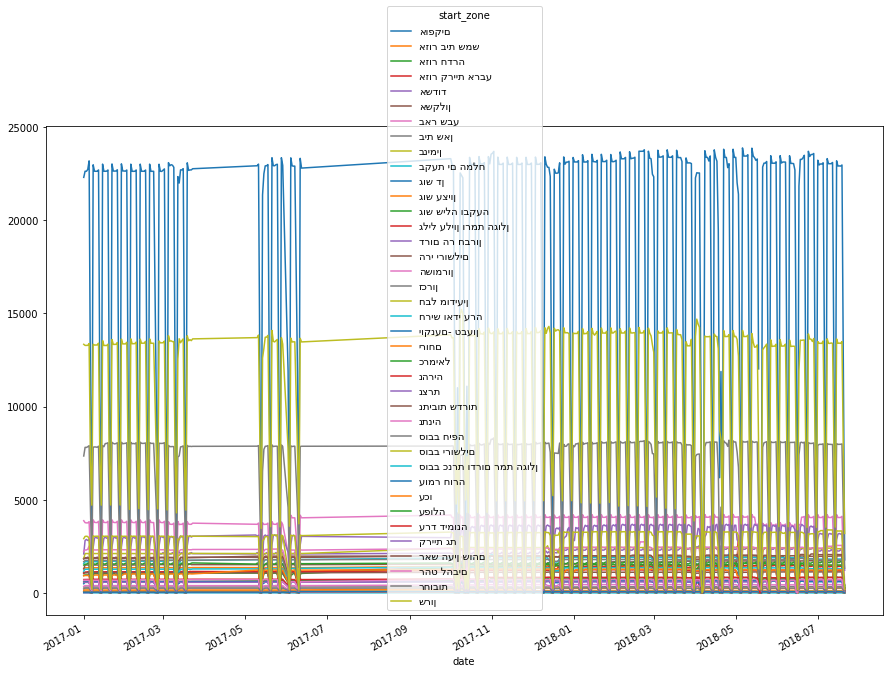

In [35]:
(rs
 .groupby(['date', 'start_zone']).num_trips.sum().unstack().plot(figsize=(15,10)))

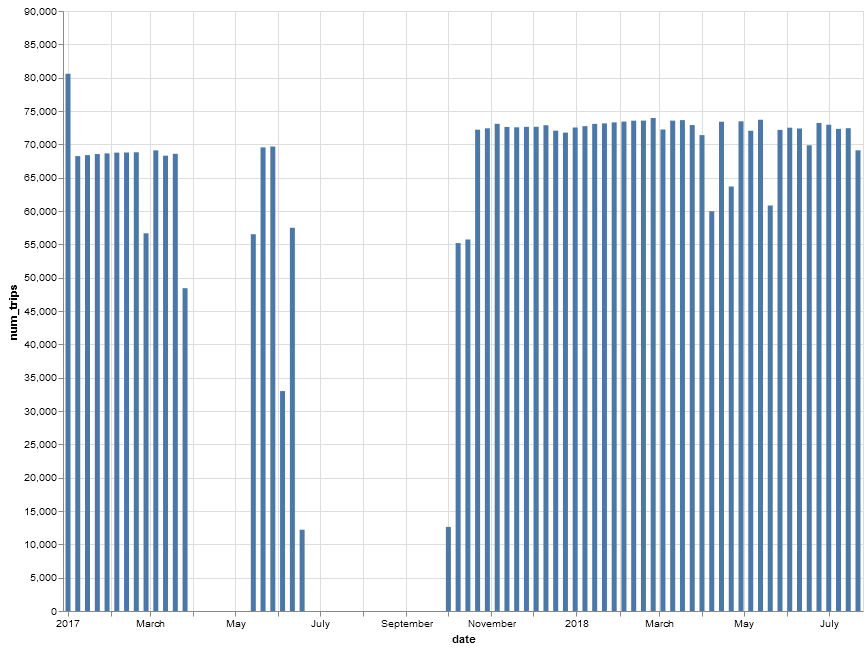

In [46]:
total_trips = (rs.set_index('date').resample('D').num_trips.sum().resample('W-SUN').mean().reset_index())

alt.Chart(total_trips).mark_bar().encode(
    x='date:T',
    y='num_trips:Q',
    tooltip=[ alt.Tooltip('date:T', format='%A, %B %e'),
             alt.Tooltip('num_trips:Q', format='.0f')],
).properties(width=800, height=600)

In [66]:
rs_zone = (rs[rs.num_trips>0]
           .groupby([pd.Grouper(key='date', freq='1d'), 'start_zone'])
           .agg({'mean_headway': 'mean', 'num_trips': 'sum'})
           .reset_index()
           .assign(dayofweek = lambda x: x['date'].dt.strftime('%A'))
          )

In [67]:
rs[['mean_headway', 'num_trips']].head()

mean_headway  num_trips
0       37.8125         26
1       28.0000         35
2           NaN          1
3       52.5000          5
4           NaN          1

In [68]:
rs_zone.head()

date       start_zone  mean_headway  num_trips dayofweek
0 2017-10-01           אופקים     98.912925        623    Sunday
1 2017-10-01     אזור בית שמש    100.214935       1432    Sunday
2 2017-10-01        אזור חדרה    111.287975        657    Sunday
3 2017-10-01  אזור קריית ארבע    170.388592        101    Sunday
4 2017-10-01            אשדוד     79.723679       2138    Sunday

In [56]:
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

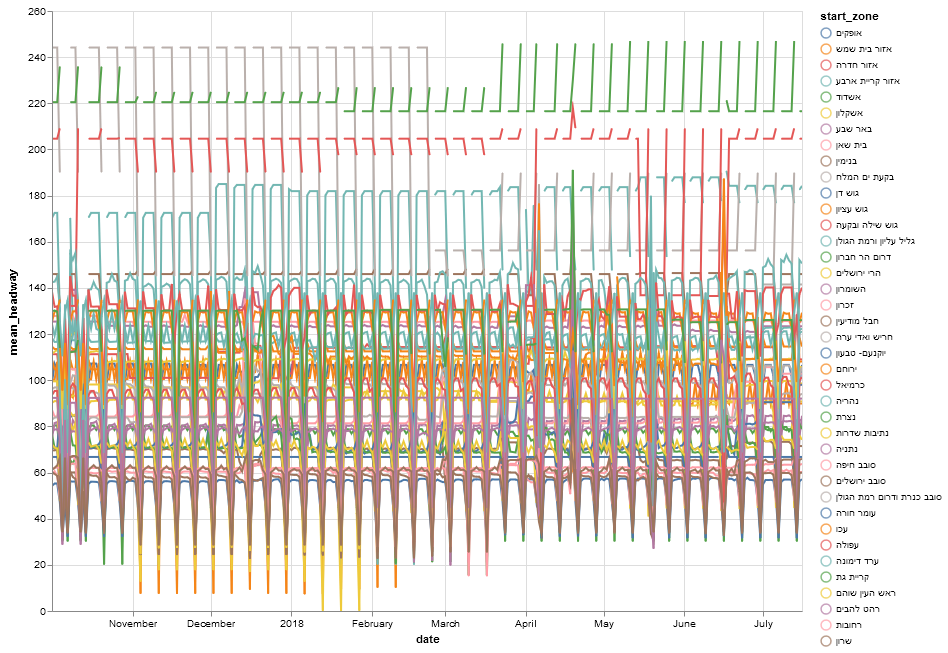

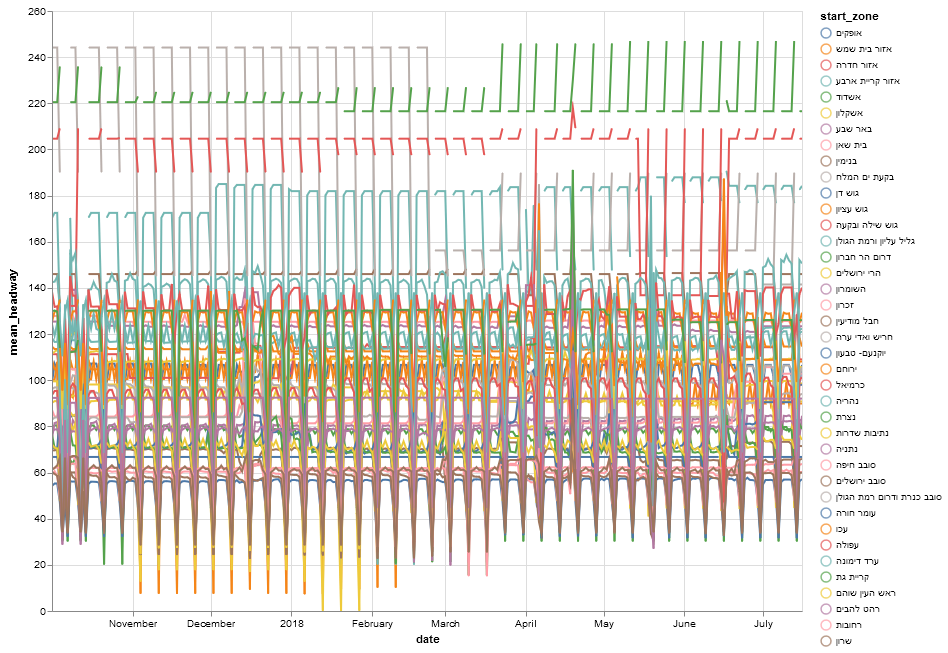

In [72]:
line = alt.Chart(rs_zone).mark_line().encode(
    x='date:T',
    y='mean_headway',
    color='start_zone',
).properties(height=600, width=750)

point = alt.Chart(rs_zone).mark_point(size=50).encode(
    x='date:T',
    y='mean_headway',
    color='start_zone',
    tooltip=[alt.Tooltip('start_zone:N'),
             alt.Tooltip('date:T', format='%A, %B %e'),
             alt.Tooltip('mean_headway:Q', format='.2f')],
    opacity=alt.value(0)

).properties(height=600, width=750, )

(line + point).interactive()


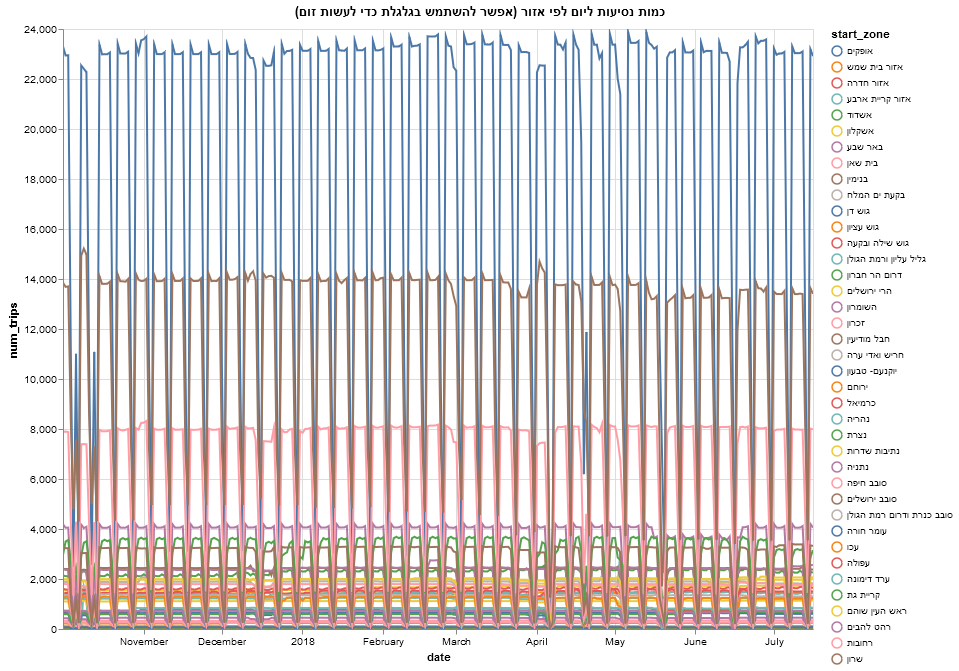

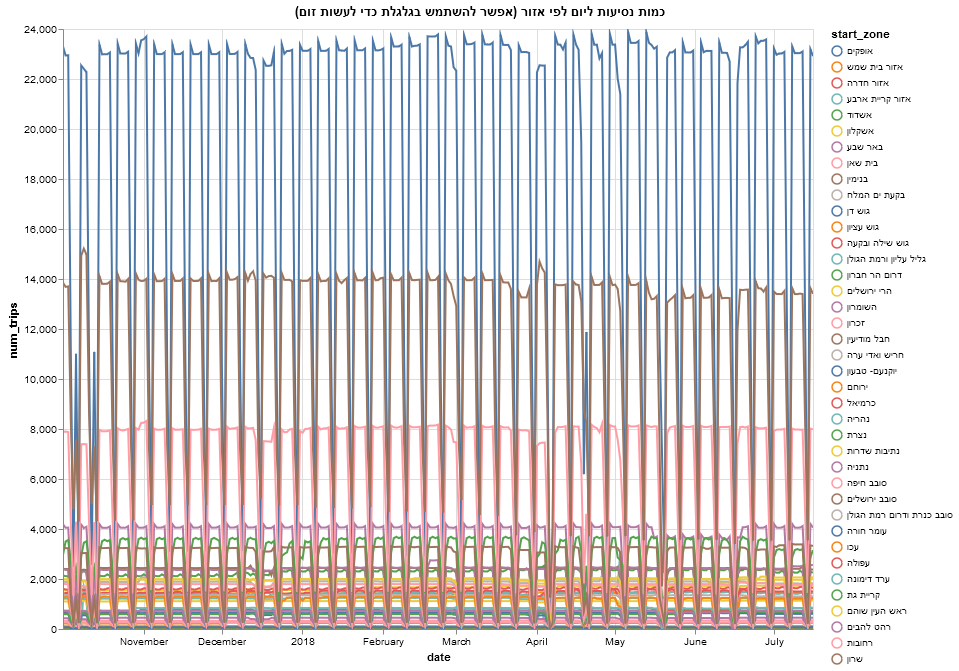

In [82]:
line = alt.Chart(rs_zone).mark_line().encode(
    x='date:T',
    y='num_trips',
    color='start_zone',
    tooltip=[alt.Tooltip('start_zone:N'),
             alt.Tooltip('date:T', format='%A, %B %e'),
             alt.Tooltip('num_trips:Q')],
).properties(height=600, width=750)

(line).properties(title='כמות נסיעות ליום לפי אזור (אפשר להשתמש בגלגלת כדי לעשות זום)').interactive()


In [ ]:
נווה זמר

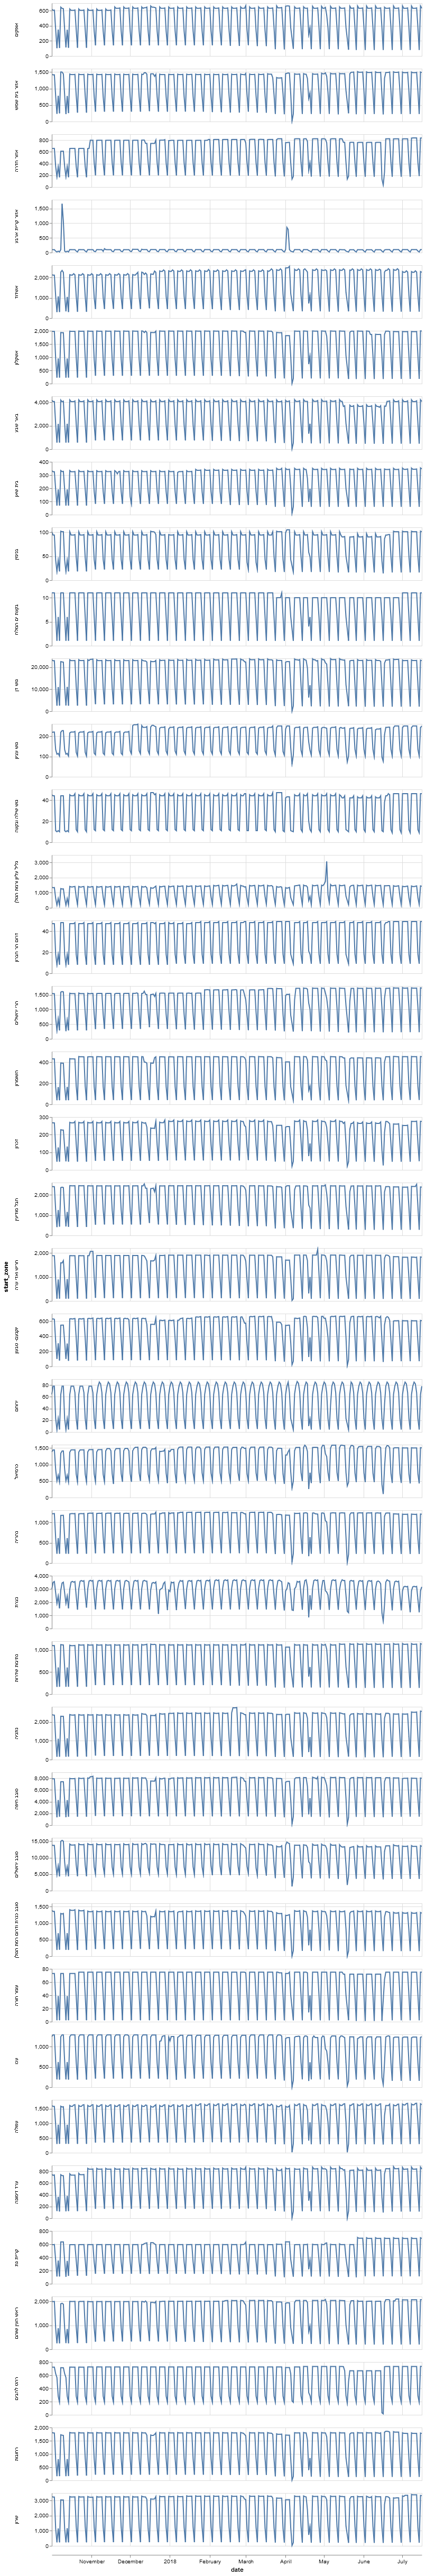

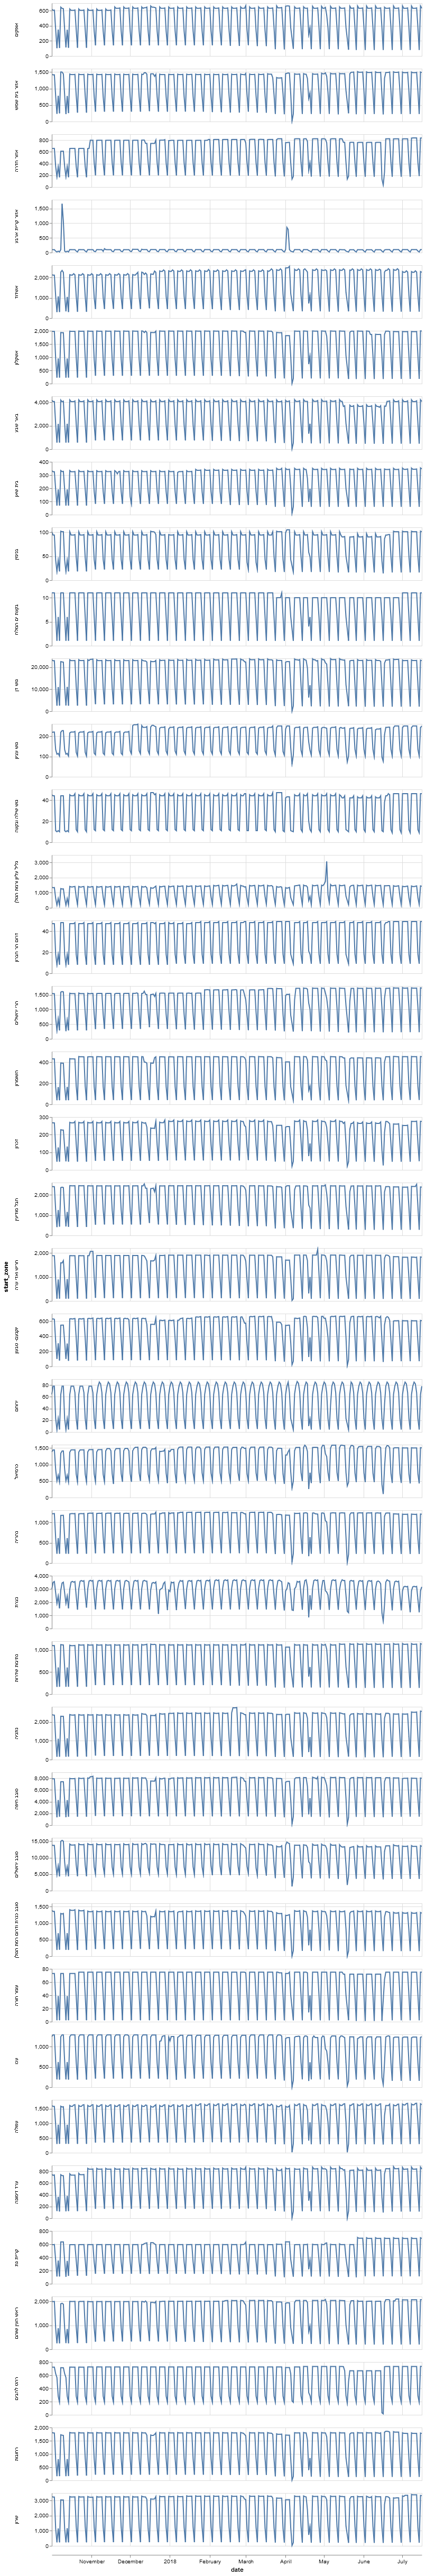

In [95]:
line = alt.Chart(rs_zone).mark_line().encode(
    x='date:T',
    y=alt.X('num_trips', title=None),
    #color='start_zone',
    tooltip=[alt.Tooltip('start_zone:N'),
             alt.Tooltip('date:T', format='%A, %B %e'),
             alt.Tooltip('num_trips:Q')],
)

(line).properties(height=100, width=700).facet(
    row='start_zone',
).resolve_scale(
    y='independent'
)


In [96]:
(line).properties(height=100, width=700).facet(
    row='start_zone',
).resolve_scale(
    y='independent'
).save('zones_separate.html')

In [80]:
(line).properties(title='כמות נסיעות ליום לפי אזור (אפשר להשתמש בגלגלת כדי לעשות זום)').interactive().save('zones.html')

In [19]:
(rs[(rs.date>='2018-03-28') & (rs.date<='2018-04-03') & (rs.start_zone=='אזור קריית ארבע')])

route_id route_short_name agency_id agency_name  \
2930    18133              381         4  אגד תעבורה   
2937    18220              365         4  אגד תעבורה   
2946    18279               43         4  אגד תעבורה   
2978    18611               42         4  אגד תעבורה   
3002    18798              380         4  אגד תעבורה   
3009    18864              260         4  אגד תעבורה   
3023    18988              256         4  אגד תעבורה   
3025    18990               59         4  אגד תעבורה   
3027    18992               57         4  אגד תעבורה   
3028    18993               57         4  אגד תעבורה   
3029    18994              257         4  אגד תעבורה   
3031    18996               50         4  אגד תעבורה   
3034    18999              382         4  אגד תעבורה   
3035    19000               52         4  אגד תעבורה   
3037    19002              254         4  אגד תעבורה   
3116    19425              383         4  אגד תעבורה   
2817    18133              381         4  אגד תעבורה   
2824    18220              365         4  אגד תעבורה   
2833    18279               43         4  אגד תעבורה   
2865    18611               42         4  אגד תעבורה   
2889    18798              380         4  אגד תעבורה   
2896    18864              260         4  אגד תעבורה   
2910    18988              256         4  אגד תעבורה   
2912    18990               59         4  אגד תעבורה   
2914    18992               57         4  אגד תעבורה   
2915    18993               57         4  אגד תעבורה   
2916    18994              257         4  אגד תעבורה   
2918    18996               50         4  אגד תעבורה   
2921    18999              382         4  אגד תעבורה   
2922    19000               52         4  אגד תעבורה   
...       ...              ...       ...         ...   
2793    18993               57         4  אגד תעבורה   
2794    18994              257         4  אגד תעבורה   
2796    18996               50         4  אגד תעבורה   
2799    18999              382         4  אגד תעבורה   
2800    19000               52         4  אגד תעבורה   
2802    19002              254         4  אגד תעבורה   
3047    20031              201         4  אגד תעבורה   
3048    20032                1         4  אגד תעבורה   
3049    20033                1         4  אגד תעבורה   
3536    22283              381         4  אגד תעבורה   
3538    22285              383         4  אגד תעבורה   
2728    18220              365         4  אגד תעבורה   
2737    18279               43         4  אגד תעבורה   
2769    18611               42         4  אגד תעבורה   
2793    18798              380         4  אגד תעבורה   
2799    18864              260         4  אגד תעבורה   
2812    18988              256         4  אגד תעבורה   
2814    18990               59         4  אגד תעבורה   
2816    18992               57         4  אגד תעבורה   
2817    18993               57         4  אגד תעבורה   
2818    18994              257         4  אגד תעבורה   
2820    18996               50         4  אגד תעבורה   
2823    18999              382         4  אגד תעבורה   
2824    19000               52         4  אגד תעבורה   
2826    19002              254         4  אגד תעבורה   
3071    20031              201         4  אגד תעבורה   
3072    20032                1         4  אגד תעבורה   
3073    20033                1         4  אגד תעבורה   
3563    22283              381         4  אגד תעבורה   
3565    22285              383         4  אגד תעבורה   

                                        route_long_name  route_type  \
2930  בית רומנו-הר חברון<->תחנה מרכזית ירושלים/הורדה...           3   
2937       'מיצד א-אספר<->משרד החוץ/שד' רבין-ירושלים-21           3   
2946  כרמי צור/מזכירות-כרמי צור<->נחל דוד/נחל קדרון-...           3   
2978  'מיצד א-אספר<->בי''ס אזורי גוש עציון-גוש עציון-21           3   
3002  שד. כלב בן יפונה/דוד המלך-קרית ארבע<->תחנה מרכ...           3   
3009       בית רומנו-הר חברון<->בנייני האומה-ירושלים-21           3   
3023  שד. כלב בן יפונה/דוד המלך-קרי

In [20]:
rs['mh_cut'] = pd.cut(rs.mean_headway, [0,10, 15, 30, 45, 60, np.inf]) 

In [21]:
zone_mh_cuts = rs.groupby(['start_zone', 'mh_cut']).size().unstack()

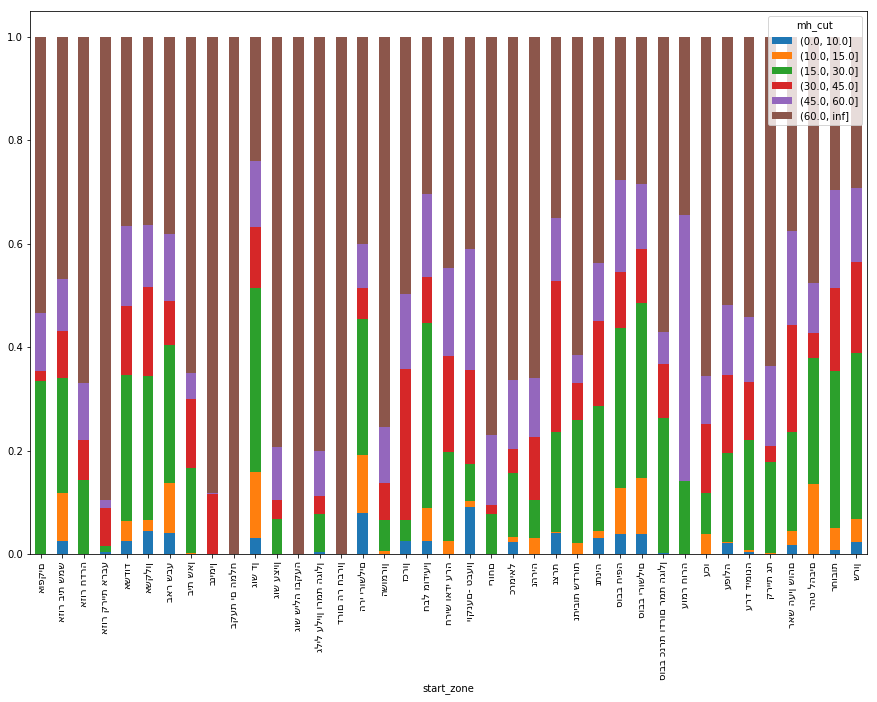

In [22]:
zone_mh_cuts.div(zone_mh_cuts.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(15,10))

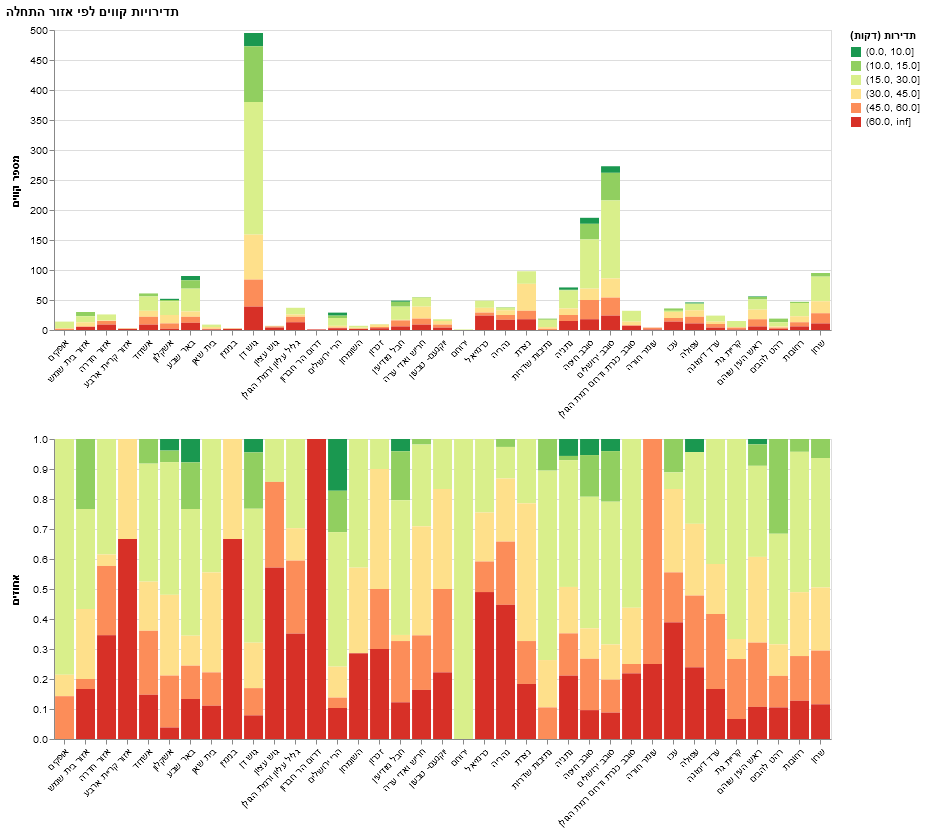

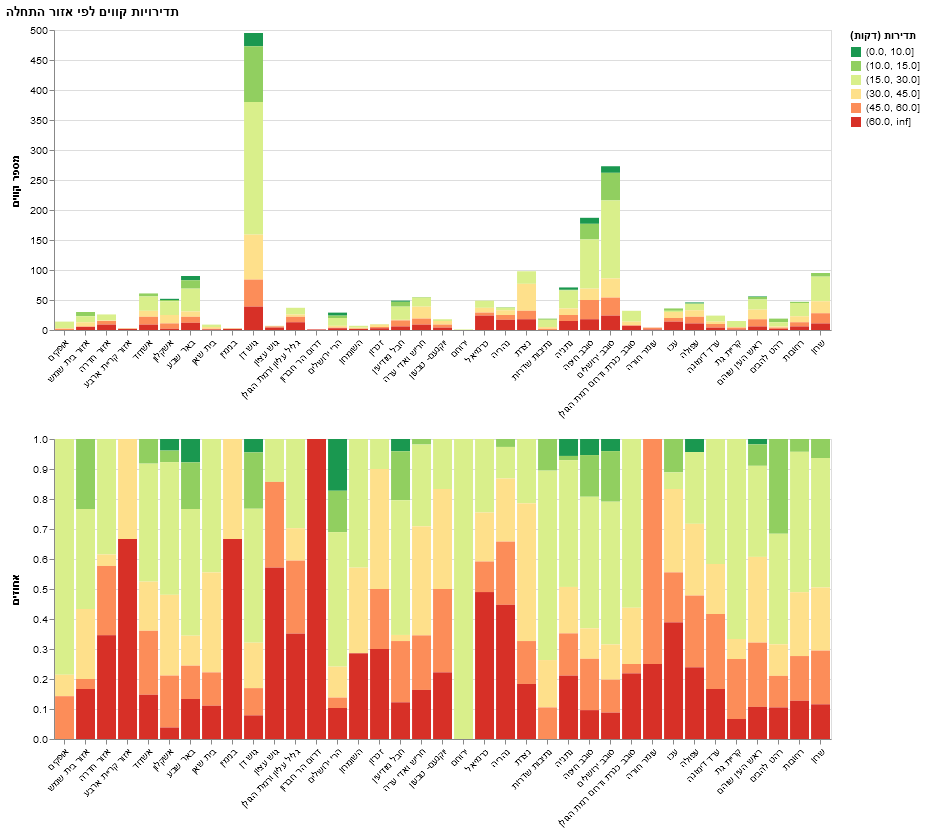

In [122]:
regular = alt.Chart(rs[(rs.date=='2018-07-15') & (rs.num_trips>10)].groupby(['start_zone', 'mh_cut']).size().reset_index().rename(columns={0:'size'})).mark_bar().encode(
    alt.X('start_zone:N', title=None),
    alt.Y('size:Q',
        axis=alt.Axis(title='מספר קווים'),
        #stack='normalize'
    ),
    alt.Color('mh_cut:O',
              scale=alt.Scale(range=['#d73027','#fc8d59','#fee08b','#d9ef8b','#91cf60','#1a9850'][::-1]),
              title='תדירות (דקות)'),
    tooltip = ['start_zone','mh_cut', 'size']
)

normalized = regular.encode(    
    alt.Y('size:Q',
        axis=alt.Axis(title='אחוזים'),
        stack='normalize'
    ),)
(regular & normalized).configure_axisX(labelAngle=-45).properties(title='תדירויות קווים לפי אזור התחלה')

In [24]:
rs[((rs.date=='2018-07-15') & (rs.num_trips>10) & (rs.mean_headway<=10))].drop_duplicates(['route_short_name', 'agency_name', 'start_zone'])[['route_short_name', 'agency_name', 'start_zone']].sort_values(['start_zone', 'agency_name', 'route_short_name'])

route_short_name                          agency_name     start_zone
2468                5                             דן בדרום         אשקלון
2688               12                           דן באר שבע        באר שבע
2708                3                           דן באר שבע        באר שבע
2666                7                           דן באר שבע        באר שבע
2669                8                           דן באר שבע        באר שבע
2686                9                           דן באר שבע        באר שבע
4975              480                                  אגד         גוש דן
1267                1                                   דן         גוש דן
5821              172                                   דן         גוש דן
4013               18                                   דן         גוש דן
5826              204                                   דן         גוש דן
3877                5                                   דן         גוש דן
4090               61                                   דן         גוש דן
4094               63                                   דן         גוש דן
4104               66                                   דן         גוש דן
4107               67                                   דן         גוש דן
5009              605                            מטרופולין         גוש דן
889               156                                קווים         גוש דן
227                 1                                קווים    הרי ירושלים
1936                2                                קווים    הרי ירושלים
233                 5                                קווים    הרי ירושלים
656                 6                                קווים    חבל מודיעין
3760               22                           אגד תעבורה          נתניה
3628                3                           אגד תעבורה          נתניה
3779              48א                           אגד תעבורה          נתניה
3707               8א                           אגד תעבורה          נתניה
5673              101                                  אגד      סובב חיפה
571               115                                  אגד      סובב חיפה
4387               17                                  אגד      סובב חיפה
742                 1                              דן צפון      סובב חיפה
747                 2                              דן צפון      סובב חיפה
738                 3                              דן צפון      סובב חיפה
51                 20                                  אגד   סובב ירושלים
1222               21                                  אגד   סובב ירושלים
67                 27                                  אגד   סובב ירושלים
1159               29                                  אגד   סובב ירושלים
4977              480                                  אגד   סובב ירושלים
349                68                                  אגד   סובב ירושלים
1694              201  ירושלים - עיסאוויה מחנה שעפאט איחוד   סובב ירושלים
1697              275                    ירושלים-הר הזיתים   סובב ירושלים
311                 1                              סיטי פס   סובב ירושלים
5449               10                              סופרבוס          עפולה
2570              280                                קווים  ראש העין שוהם

In [25]:
rs[((rs.mean_headway<=10))].shape

(37228, 32)

In [26]:
rs[((rs.date=='2018-07-15'))].groupby(['route_short_name', 'agency_name', 'start_zone']).size().sort_values(ascending=False).reset_index()

route_short_name        agency_name                 start_zone   0
0                 174                אגד                     גוש דן  13
1                   1          מטרופולין                       שרון  12
2                 101             אפיקים                    השומרון  12
3                  54              קווים                חבל מודיעין  11
4                   1              קווים                     גוש דן  10
5                  70             אפיקים                    השומרון  10
6                 480                אגד               סובב ירושלים  10
7                  13                אגד                     רחובות   9
8                  25                 דן                     גוש דן   9
9                  59              קווים                חבל מודיעין   9
10                 56              קווים                חבל מודיעין   9
11                511        נתיב אקספרס      גליל עליון ורמת הגולן   9
12                  1                אגד              חריש ואדי ערה   9
13                102             אפיקים                    השומרון   8
14                 80          מטרופולין                 ערד דימונה   8
15                  6                 דן                     גוש דן   8
16                 58          מטרופולין                    באר שבע   8
17                 58              קווים                חבל מודיעין   8
18                350            סופרבוס                      עפולה   8
19                 55              קווים                     גוש דן   7
20                 12         אגד תעבורה                      נתניה   7
21                 57              קווים                חבל מודיעין   7
22                  3                 דן                     גוש דן   7
23                 56              קווים                     גוש דן   7
24                 18                 דן                     גוש דן   7
25                522        נתיב אקספרס      גליל עליון ורמת הגולן   7
26                 58  מועצה אזורית גולן      גליל עליון ורמת הגולן   7
27                 65                 דן                     גוש דן   7
28                 11                אגד                     גוש דן   7
29                  2              קווים                     גוש דן   7
...               ...                ...                        ...  ..
3313              312             אפיקים                     גוש דן   1
3314               31         גי.בי.טורס  סובב כנרת ודרום רמת הגולן   1
3315               56                אגד               סובב ירושלים   1
3316               56                אגד                     כרמיאל   1
3317               56                אגד                    באר שבע   1
3318               31              קווים              חריש ואדי ערה   1
3319              310                אגד                     אשקלון   1
3320              310                אגד                     גוש דן   1
3321              310              קווים                חבל מודיעין   1
3322              310              קווים               סובב ירושלים   1
3323              559          מטרופולין                 ערד דימונה   1
3324              311                אגד                     גוש דן   1
3325              559          מטרופולין               אזור בית שמש   1
3326              312             אפיקים                      אשדוד   1
3327              558                אגד                 ערד דימונה   1
3328              557                אגד                     גוש דן   1
3329              313             אפיקים                      אשדוד   1
3330              313             אפיקים                     גוש דן   1
3331              313        נתיב אקספרס                      נהריה   1
3332              313        נתיב אקספרס                        עכו   1
3333              314             אפיקים                      אשדוד   1
3334              314             אפיקים                     גוש דן   1
3335              315             אפיקים                      אשדוד   1
3336              558                אגד     

In [27]:
rs[((rs.date=='2018-07-15'))].shape

(5928, 32)

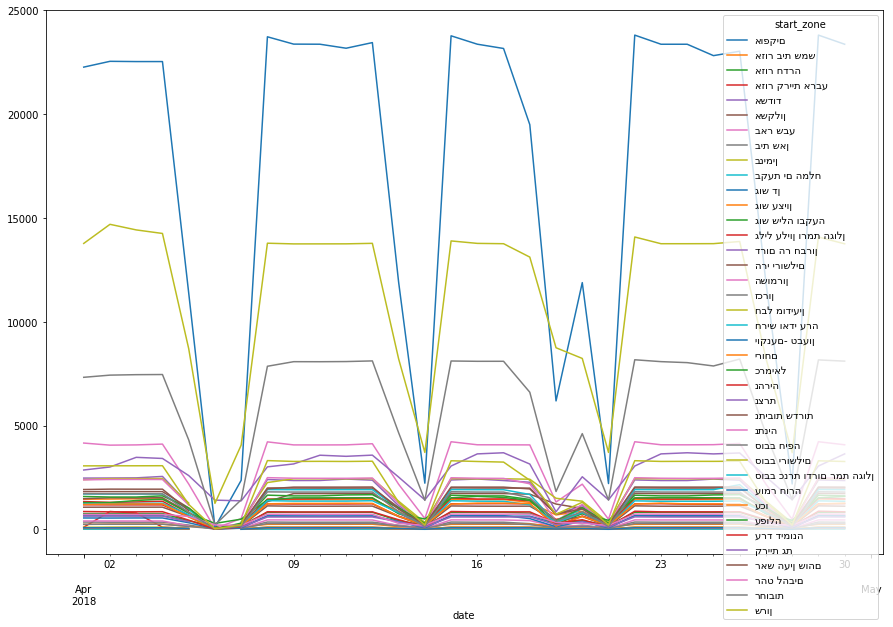

In [28]:
rs[rs.date.dt.month==4].groupby(['date', 'start_zone']).num_trips.sum().unstack().plot(figsize=(15,10))

In [29]:
rs[(rs.dayofweek=='Friday')& (rs.agency_name=='רכבת ישראל')].groupby(['date', 'end_zone']).end_time.max().unstack()

end_zone   אזור בית שמש    אשקלון   באר שבע   בית שאן    גוש דן חבל מודיעין  \
date                                                                          
2017-10-06     14:59:00  16:55:00  16:38:00  16:21:00  16:35:00    16:46:00   
2017-10-13     14:59:00  16:55:00  16:38:00  16:21:00  16:35:00    16:46:00   
2017-10-20     14:59:00  16:55:00  16:38:00  16:21:00  16:35:00    16:46:00   
2017-10-27     14:59:00  16:55:00  16:38:00  16:21:00  16:35:00    16:46:00   
2017-11-03     14:59:00  16:55:00  16:31:00  16:21:00  16:35:00    16:46:00   
2017-11-10     13:59:00  15:55:00  15:38:00  15:21:00  15:45:00    15:46:00   
2017-11-17     13:59:00  15:55:00  15:38:00  15:21:00  15:45:00    15:46:00   
2017-11-24     13:59:00  15:55:00  15:38:00  15:21:00  15:45:00    15:46:00   
2017-12-01     13:59:00  15:55:00  15:38:00  15:21:00  15:45:00    15:46:00   
2017-12-08     13:59:00  15:55:00  15:38:00  15:21:00  15:35:00         NaN   
2017-12-15     13:59:00  15:55:00  15:38:00  15:21:00  15:45:00    15:46:00   
2017-12-22     13:59:00  15:55:00  15:38:00  15:21:00  15:45:00    15:46:00   
2017-12-29     13:59:00  15:55:00  15:38:00  15:21:00  15:45:00    15:46:00   
2018-01-05     13:59:00  15:55:00  15:38:00  15:21:00  15:45:00    15:46:00   
2018-01-12     13:59:00  15:55:00  15:38:00  15:21:00  15:45:00    15:46:00   
2018-01-19     13:59:00  15:55:00  15:38:00  15:21:00  15:45:00    15:46:00   
2018-01-26     13:59:00  15:55:00  15:38:00  15:21:00  15:45:00    15:46:00   
2018-02-02     13:59:00  15:55:00  15:38:00  15:21:00  15:45:00    15:46:00   
2018-02-09     13:59:00  15:55:00  15:38:00  15:21:00  15:45:00    15:46:00   
2018-02-16     13:59:00  15:55:00  15:38:00  15:21:00  15:45:00         NaN   
2018-02-23     13:59:00  15:55:00  15:38:00  15:21:00  15:35:00         NaN   
2018-03-02     13:59:00  15:55:00  15:38:00  15:21:00  15:45:00         NaN   
2018-03-09     13:59:00  15:55:00  15:38:00  15:21:00  15:45:00         NaN   
2018-03-16     13:59:00  15:55:00  15:38:00  15:21:00  15:45:00         NaN   
2018-03-23     15:59:00  17:55:00  17:38:00  17:21:00  17:35:00         NaN   
2018-03-30     15:59:00  17:55:00  17:38:00  17:21:00  17:35:00         NaN   
2018-04-06     15:59:00  17:39:00  17:38:00  17:21:00  17:41:00         NaN   
2018-04-13     15:59:00  17:39:00  17:38:00  17:21:00  17:41:00         NaN   
2018-04-20     15:59:00  17:39:00  17:38:00  17:21:00  17:41:00         NaN   
2018-04-27     15:59:00  17:39:00  17:38:00  17:21:00  17:41:00         NaN   
2018-05-04     15:59:00  17:39:00  17:38:00  17:21:00  17:41:00         NaN   
2018-05-11     15:59:00  17:39:00  17:38:00  17:21:00  17:41:00         NaN   
2018-05-18     15:59:00  17:39:00  17:38:00  17:21:00  17:41:00         NaN   
2018-05-25     15:59:00  17:39:00  17:38:00  17:21:00  17:41:00         NaN   
2018-06-01     15:59:00  17:39:00  17:38:00  17:21:00  17:41:00         NaN   
2018-06-08     15:59:00  17:39:00  17:38:00  17:21:00  17:41:00         NaN   
2018-06-15     15:59:00  17:39:00  17:38:00  17:21:00  17:41:00         NaN   
2018-06-22     15:59:00  17:39:00  17:38:00  17:21:00  17:41:00         NaN   
2018-06-29     15:59:00  17:39:00  17:38:00  17:21:00  17:41:00         NaN   
2018-07-06     15:59:00  17:39:00  17:38:00  17:21:00  17:41:00         NaN   
2018-07-13     15:59:00  17:39:00  17:38:00  17:21:00  17:41:00         NaN   

end_zone   חריש ואדי ערה יוקנעם- טבעון    כרמיאל     נהריה נתיבות שדרות  \
date                                                                      
2017-10-06      16:20:00      15:43:00  16:51:00  16:00:00          NaN   
2017-10-13      16:20:00      15:43:00  16:51:00  16:00:00          NaN   
2017-10-20      16:20:00      15:43:00  16:51:00  16:00:00          NaN   
2017-10-27      16:20:00      15:43:00  16:51:00  16:00:00          NaN   
2017-11-03      14:32:00      14:43:00  16:51:00  17:00:00          NaN   
2017-11-10      15:20:00      14:43:00  15:51:00  15:00:00          NaN   
20

In [30]:
import glob
ts = (pd.concat([pd.read_pickle(f, compression='gzip') 
                 for f in glob.glob('data\\gtfs_stats_MOD\\*_trip_stats.pkl.gz')[:5]])
      .assign(date = lambda x: pd.to_datetime(x.date)))

In [31]:
ts.head().T


0  \
trip_id                                             10021427_011017   
route_id                                                      10376   
route_short_name                                                215   
route_long_name   מרכזית המפרץ/שדרות ההסתדרות-חיפה<->שדרות נשיאי...   
agency_id                                                         3   
agency_name                                                     אגד   
route_type                                                        3   
direction_id                                                      0   
shape_id                                                      88239   
num_stops                                                        52   
start_time                                                 00:00:00   
end_time                                                   00:55:55   
start_stop_id                                                 36133   
end_stop_id                                                   20702   
start_stop_code                                               47915   
end_stop_code                                                 53565   
start_stop_name                         מרכזית המפרץ/שדרות ההסתדרות   
end_stop_name                                שדרות נשיאי ישראל/אסיף   
start_zone                                                סובב חיפה   
end_zone                                                     כרמיאל   
is_loop                                                           0   
duration                                                   0.931944   
distance                                                      44033   
speed                                                       47.2485   
date                                            2017-10-01 00:00:00   

                                                                  1  \
trip_id                                             10021428_011017   
route_id                                                      10376   
route_short_name                                                215   
route_long_name   מרכזית המפרץ/שדרות ההסתדרות-חיפה<->שדרות נשיאי...   
agency_id                                                         3   
agency_name                                                     אגד   
route_type                                                        3   
direction_id                                                      0   
shape_id                                                      88239   
num_stops                                                        52   
start_time                                                 01:00:00   
end_time                                                   01:55:55   
start_stop_id                                                 36133   
end_stop_id                                                   20702   
start_stop_code                                               47915   
end_stop_code                                                 53565   
start_stop_name                         מרכזית המפרץ/שדרות ההסתדרות   
end_stop_name                                שדרות נשיאי ישראל/אסיף   
start_zone                                                סובב חיפה   
end_zone                                                     כרמיאל   
is_loop                                                           0   
duration                                                   0.931944   
distance                                                      44033   
speed                                                       47.2485   
date                                            2017-10-01 00:00:00   

                                                                  2  \
trip_id                                             10021429_011017   
route_id                                                      10376   
route_short_name                                                215   
route_long_name   מרכזית המפרץ/שדרות ההסתדרות-חיפה<->שדרות נשיאי...   
agency_id        

In [32]:
rs.head().T

0  \
route_id                                                            1   
route_short_name                                                    1   
agency_id                                                          25   
agency_name                                                    אפיקים   
route_long_name     תחנת רכבת יבנה מערב-יבנה<->תחנת רכבת מזרח-יבנה-1#   
route_type                                                          3   
num_trips                                                          26   
num_trip_starts                                                    26   
num_trip_ends                                                      26   
is_loop                                                             0   
is_bidirectional                                                    0   
start_time                                                   05:10:00   
end_time                                                     21:54:07   
max_headway                                                        65   
min_headway                                                        20   
mean_headway                                                  37.8125   
peak_num_trips                                                      1   
peak_start_time                                              05:10:00   
peak_end_time                                                05:29:07   
service_distance                                               183170   
service_duration                                              8.28389   
service_speed                                                 22.1116   
mean_trip_distance                                               7045   
mean_trip_duration                                           0.318611   
start_stop_id                                                   38725   
end_stop_id                                                     15745   
num_stops                                                          18   
start_zone                                                     רחובות   
end_zone                                                       רחובות   
date                                              2017-10-01 00:00:00   
dayofweek                                                      Sunday   
mh_cut                                                   (30.0, 45.0]   

                                                                    1  \
route_id                                                           10   
route_short_name                                                    4   
agency_id                                                          25   
agency_name                                                    אפיקים   
route_long_name     תחנת רכבת מזרח-יבנה<->תחנת רכבת יבנה מערב-יבנה-2#   
route_type                                                          3   
num_trips                                                          35   
num_trip_starts                                                    35   
num_trip_ends                                                      35   
is_loop                                                             0   
is_bidirectional                                                    0   
start_time                                                   06:05:00   
end_time                                                     22:51:36   
max_headway                                                        50   
min_headway                                                        10   
mean_headway                                                       28   
peak_num_trips                                                      2   
peak_start_time                                              15:55:00   
peak_end_time                                                16:06:36   
service_distance                                               283920   
service_duration                                                 12.6   
service_speed                                       

In [ ]:
day_series = df.date.copy()

day_series[df.start_time < cutoff] = df.loc[df.start_time < cutoff, 'date'] - datetime.timedelta(days=1)

In [112]:
rs[((rs.date=='2018-07-15') & (rs.start_zone=='שרון')& (rs.agency_name=='מטרופולין') & (rs.route_short_name.isin(['9', '19', '51', '52'])))].T

3528  \
route_id                                                        20818   
route_short_name                                                   19   
agency_id                                                          15   
agency_name                                                 מטרופולין   
route_long_name     בן ציון מיכאלי/הרכבת-הרצליה<->נעמי שמר/וייצמן-...   
route_type                                                          3   
num_trips                                                          39   
num_trip_starts                                                    39   
num_trip_ends                                                      39   
is_loop                                                             0   
is_bidirectional                                                    0   
start_time                                                   06:00:00   
end_time                                                     19:50:13   
max_headway                                                        25   
min_headway                                                        15   
mean_headway                                                  20.1471   
peak_num_trips                                                      4   
peak_start_time                                              06:55:00   
peak_end_time                                                07:10:13   
service_distance                                               872976   
service_duration                                              45.6408   
service_speed                                                 19.1271   
mean_trip_distance                                              22384   
mean_trip_duration                                            1.17028   
start_stop_id                                                   40799   
end_stop_id                                                     42462   
num_stops                                                          56   
start_zone                                                       שרון   
end_zone                                                         שרון   
date                                              2018-07-15 00:00:00   
dayofweek                                                      Sunday   
mh_cut                                                   (15.0, 30.0]   

                                                                 3529  \
route_id                                                        20819   
route_short_name                                                    9   
agency_id                                                          15   
agency_name                                                 מטרופולין   
route_long_name     נעמי שמר/משה וילנסקי-רעננה<->בן ציון מיכאלי/הר...   
route_type                                                          3   
num_trips                                                          40   
num_trip_starts                                                    40   
num_trip_ends                                                      40   
is_loop                                                             0   
is_bidirectional                                                    0   
start_time                                                   05:30:00   
end_time                                                     19:52:49   
max_headway                                                        25   
min_headway                                                        15   
mean_headway                                                  20.1471   
peak_num_trips                                                      4   
peak_start_time                                              06:55:00   
peak_end_time                                                07:12:49   
service_distance                                               925240   
service_duration                                              48.5444   
service_speed                                    

In [114]:
rs[((rs.date=='2018-07-15') & (rs.start_zone=='שרון')& (rs.agency_name=='מטרופולין') & (rs.route_short_name.isin(['9', '19', '51', '52'])))].num_trips.sum()

197

In [118]:
rs[(rs.date=='2018-07-15') & (rs.agency_name=='רכבת ישראל') & (rs.route_long_name.str.contains('ראשון'))]

route_id route_short_name agency_id agency_name  \
3814    22103              NaN         2  רכבת ישראל   
3849    22317              NaN         2  רכבת ישראל   
3979    23151              NaN         2  רכבת ישראל   
3980    23152              NaN         2  רכבת ישראל   

                                      route_long_name  route_type  num_trips  \
3814                    לוד-לוד<->ראשונים-ראשון לציון           2         17   
3849                    ראשונים-ראשון לציון<->לוד-לוד           2         17   
3979  רשל''צ משה דיין-ראשון לציון<->רעננה מערב-הרצליה           2         12   
3980  רעננה מערב-הרצליה<->רשל''צ משה דיין-ראשון לציון           2         15   

      num_trip_starts  num_trip_ends  is_loop      ...       \
3814               17             17        0      ...        
3849               17             17        0      ...        
3979               12             12        0      ...        
3980               15             15        0      ...        

      mean_trip_distance mean_trip_duration start_stop_id  end_stop_id  \
3814              7800.0           0.133333         37338        37298   
3849              7800.0           0.150000         37298        37338   
3979             41300.0           1.166667         37294        42417   
3980             41300.0           1.133333         42417        37294   

      num_stops  start_zone  end_zone       date dayofweek        mh_cut  
3814          2      גוש דן    גוש דן 2018-07-15    Sunday   (60.0, inf]  
3849          2      גוש דן    גוש דן 2018-07-15    Sunday  (45.0, 60.0]  
3979         17      גוש דן      שרון 2018-07-15    Sunday   (60.0, inf]  
3980         17        שרון    גוש דן 2018-07-15    Sunday   (60.0, inf]  

[4 rows x 32 columns]

In [121]:
rs[rs.route_id.isin(['23152', '23151'])].T

3903  \
route_id                                                      23151   
route_short_name                                                NaN   
agency_id                                                         2   
agency_name                                              רכבת ישראל   
route_long_name     רשל''צ משה דיין-ראשון לציון<->רעננה מערב-הרצליה   
route_type                                                        2   
num_trips                                                        13   
num_trip_starts                                                  13   
num_trip_ends                                                    13   
is_loop                                                           0   
is_bidirectional                                                  0   
start_time                                                 06:01:00   
end_time                                                   20:11:00   
max_headway                                                     390   
min_headway                                                      30   
mean_headway                                                76.6667   
peak_num_trips                                                    3   
peak_start_time                                            07:01:00   
peak_end_time                                              07:11:00   
service_distance                                             536900   
service_duration                                            15.1667   
service_speed                                                  35.4   
mean_trip_distance                                            41300   
mean_trip_duration                                          1.16667   
start_stop_id                                                 37294   
end_stop_id                                                   42417   
num_stops                                                        17   
start_zone                                                   גוש דן   
end_zone                                                       שרון   
date                                            2018-07-03 00:00:00   
dayofweek                                                   Tuesday   
mh_cut                                                  (60.0, inf]   

                                                               3904  \
route_id                                                      23152   
route_short_name                                                NaN   
agency_id                                                         2   
agency_name                                              רכבת ישראל   
route_long_name     רעננה מערב-הרצליה<->רשל''צ משה דיין-ראשון לציון   
route_type                                                        2   
num_trips                                                        16   
num_trip_starts                                                  16   
num_trip_ends                                                    16   
is_loop                                                           0   
is_bidirectional                                                  0   
start_time                                                 05:44:00   
end_time                                                   20:37:00   
max_headway                                                     390   
min_headway                                                      30   
mean_headway                                                62.7273   
peak_num_trips                                                    3   
peak_start_time                                            06:44:00   
peak_end_time                                              06:52:00   
service_distance                                             660800   
service_duration                                            18.1333   
service_speed                                               36.4412   
mean_trip_distance                                            41300   
mean_trip_durat

## New version - zones left merge

In [38]:
import partridge as ptg

In [40]:
rsn = (pd.concat([pd.read_pickle(f, compression='gzip') 
                 for f in glob.glob('data\\gtfs_stats_MOD_zones_left\\*_route_stats.pkl.gz')])
      .assign(date = lambda x: pd.to_datetime(x.date))
      .assign(dayofweek = lambda x: x['date'].dt.strftime('%A')))

In [41]:
rsn.head().T

0  \
route_id                                                            1   
route_short_name                                                    1   
agency_id                                                          25   
agency_name                                                    אפיקים   
route_long_name     תחנת רכבת יבנה מערב-יבנה<->תחנת רכבת מזרח-יבנה-1#   
route_type                                                          3   
num_trips                                                          26   
num_trip_starts                                                    26   
num_trip_ends                                                      26   
is_loop                                                             0   
is_bidirectional                                                    0   
start_time                                                   05:10:00   
end_time                                                     21:54:07   
max_headway                                                        60   
min_headway                                                        20   
mean_headway                                                     37.5   
peak_num_trips                                                      1   
peak_start_time                                              05:10:00   
peak_end_time                                                05:29:07   
service_distance                                               183170   
service_duration                                              8.28389   
service_speed                                                 22.1116   
mean_trip_distance                                               7045   
mean_trip_duration                                           0.318611   
start_stop_id                                                   38725   
end_stop_id                                                     15745   
start_stop_lat                                                31.8907   
start_stop_lon                                                34.7312   
end_stop_lat                                                  31.8619   
end_stop_lon                                                  34.7444   
num_stops                                                          18   
start_zone                                                     רחובות   
end_zone                                                       רחובות   
num_zones                                                           1   
num_zones_missing                                                   0   
date                                              2017-01-01 00:00:00   
dayofweek                                                      Sunday   

                                                                    1  \
route_id                                                           10   
route_short_name                                                    4   
agency_id                                                          25   
agency_name                                                    אפיקים   
route_long_name     תחנת רכבת מזרח-יבנה<->תחנת רכבת יבנה מערב-יבנה-2#   
route_type                                                          3   
num_trips                                                          35   
num_trip_starts                                                    35   
num_trip_ends                                                      35   
is_loop                                                             0   
is_bidirectional                                                    0   
start_time                                                   06:05:00   
end_time                                                     22:51:36   
max_headway                                                        50   
min_headway                                                        10   
mean_headway                                                       28   
peak_num_trips                                      

In [45]:
rsn[rsn.num_zones_missing>0].groupby('date').num_zones_missing.mean()

date
2017-01-01    26.298507
2017-01-02    26.417910
2017-01-03    26.409091
Name: num_zones_missing, dtype: float64

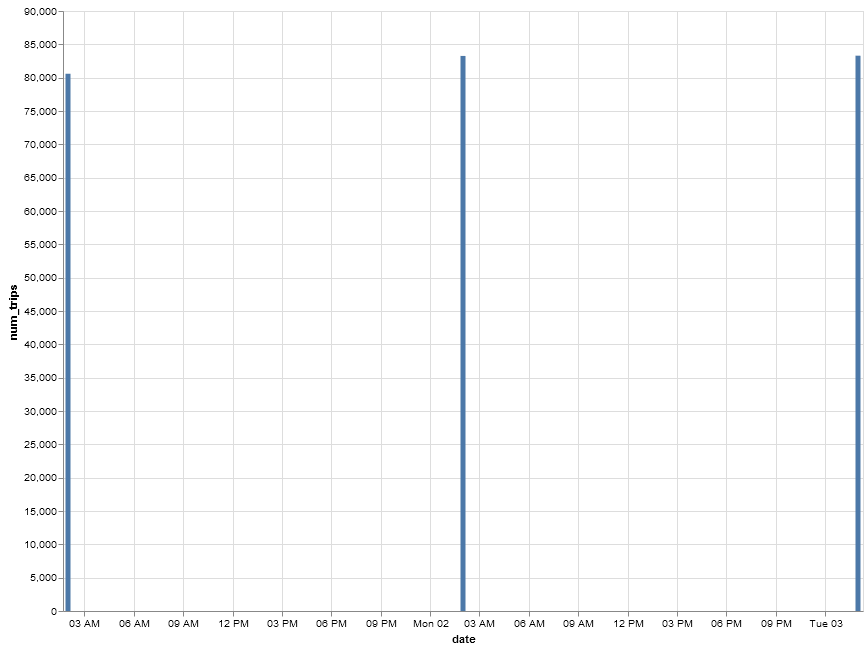

In [50]:
total_trips = (rsn.set_index('date').resample('D').num_trips.sum()#.resample('W-SUN').mean()
               .reset_index()
              )

alt.Chart(total_trips).mark_bar().encode(
    x='date:T',
    y='num_trips:Q',
    tooltip=[ alt.Tooltip('date:T', format='%A, %B %e'),
             alt.Tooltip('num_trips:Q', format='.0f')],
).properties(width=800, height=600)

## Read filtered feed

In [51]:
feed = ptg.raw_feed('data/filtered_feeds/2017-01-01.zip')